#Implementation of the Gradient Descent
We are implementing $$
X_t^i = \frac{2bf} {\sqrt{|\gamma|}}\sum_{k=1}^n(A_{bi\_tensor} - \hat{A})_kA_{tissue}(q_k^T\frac{\partial D}{\partial X^i}q_k) + \frac{\alpha}{\sqrt{|\gamma|}}\partial_\mu(\sqrt{|\gamma|} \gamma^{\nu \mu}\partial_\nu X^i) + \alpha\Gamma^i_{qp} \gamma^{\nu \mu}\partial_\mu X^q \partial_\nu X^p
$$
And
$$ f_t  = -2\sum_{k=1}^n(A_{bi\_tensor} - \hat{A})_k(A_{tissue} - A_{water})_k$$

$$\space$$
As appears in the paper "Free water elimination and mapping for diffusion MRI"


Detailed derivations and notation can be found in the pdf report of this project.

#Create synthetic data
The data is created over a spatial domian of (31, 31, 31) voxels.We take the matrix of applied gradients to be

$$Q = \begin{pmatrix}
- & e_1 & - \\
- & e_2 & - \\
- & e_3 & - \\
-& e_1 + e_2&- \\
-&e_1 + e_3&- \\
-&e_2 + e_3 &-
\end{pmatrix}$$

Where $e_1, e_2, e_3$ is the standart basis in $\mathbb{R}^3$.

We take two positive definite matrices

$$A = \begin{pmatrix}
3 & 0 & 0 \\
0 & 3 & 0 \\
0 & 0 & 3
\end{pmatrix}, ~~~~ B = \begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 2
\end{pmatrix}$$

And define the data to be the tensor D

$$D[l, i, j, k] = \begin{cases}
q_l^TAq_l, & \text{if } (i-15)^2 + (j-15)^2 + (k-15)^2 \ge 100,\\
q_l^TBq_l  & \text{else }
\end{cases}$$

Following the implementation I added a slice of the data. At each voxel the color is the projection of the underlying principle eigenvector of the positive definite matrix at this voxel on the standard basis $e_1,e_2,e_3$. Namely,

$$R[i,j,k] = <eigen_{λ_{max}}, e_1>$$
$$G[i,j,k] = <eigen_{λ_{max}}, e_2>$$
$$B[i,j,k] = <eigen_{λ_{max}}, e_3>$$

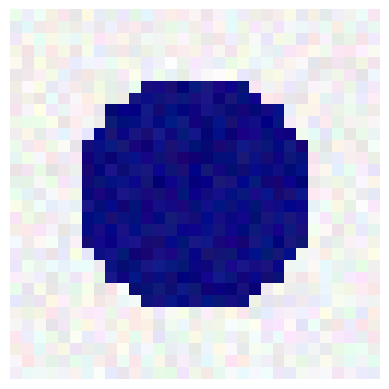

In [86]:
import numpy as np
import matplotlib.pyplot as plt

syntehtic_data = np.zeros((6, 31, 31, 31), dtype=float)

# Create grid of indices
I, J, K = np.ogrid[:31, :31, :31]

# Compute squared distance from center (15, 15, 15)
dist2 = (I - 15)**2 + (J - 15)**2 + (K - 15)**2

# Masks
mask_inside = dist2 < 100
mask_outside = ~mask_inside

# Assign values
syntehtic_data[:, mask_inside] = np.array([1, 1, 2, 2, 3, 3])[:, None]   #Here we assign to each coordinate q_i^TDq_i
syntehtic_data[:, mask_inside] += np.random.uniform(0, 0.25, size=(6, mask_inside.sum()))
syntehtic_data[:, mask_outside] = np.array([3, 3, 3, 6, 6, 6])[:, None]
syntehtic_data[:, mask_outside] += np.random.uniform(0, 0.25, size=(6, mask_outside.sum()))


Z = np.zeros((3, 31, 31, 31))

for i in range(31):
    for j in range(31):
        for k in range(31):

            # Projections (dot products)
            R = syntehtic_data[0, i, j, k]
            G = syntehtic_data[1, i, j, k]
            B = syntehtic_data[2, i, j, k]

            Z[:, i, j, k] = [R, G, B]

# Extract slice at i=15
slice_img = np.moveaxis(Z[:, 15, :, :], 0, -1)  # shape (31,31,3)

# Normalize to [0,1] for plotting
slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())

plt.imshow(slice_img)
plt.axis("off")
plt.show()


#Implementing the metric matrix h in Iwasawa coordinates given by

$$h = \begin{pmatrix}
1 & 0 & 0 & 0& 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0& 0& \frac{1}{x_1^2}& 0 & 0 & 0& 0& 0\\
0 & 0 & 0 & 0 & \frac{1}{x_2^2} & 0 & 0 & 0 & 0\\
0 & 0 &0 & 0 & 0 & \frac{1}{x_3^2} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 2(\frac{x_1}{x_2} + \frac{x_6^2x_1}{x_3}) & \frac{-2x_6x_1}{x_3} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \frac{-2x_6x_1}{x_3} & \frac{2x_1}{x_3} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac{2x_2}{x_3}\\
\end{pmatrix}$$

In [72]:
import numpy as np
# Implementing for the metric matrix h
# Added epsilon for numerical stability
def h(tensor):
    eps = 1e-5
    x1, x2, x3, x4, x5, x6 = tensor.ravel()
    M = np.zeros((9, 9))

    # Identity part
    np.fill_diagonal(M[:3, :3], 1)

    # Diagonal with reciprocal squares
    M[3, 3] = 1 / (x1**2 + eps)
    M[4, 4] = 1 / (x2**2 + eps)
    M[5, 5] = 1 / (x3**2 + eps)

    # Bottom-right block
    M[6, 6] = 2 * (x1/(np.abs(x2)+ eps) + (x6**2 * x1)/(np.abs(x3) + eps))
    M[6, 7] = -2 * x6 * x1 / (np.abs(x3) + eps)
    M[7, 6] = -2 * x6 * x1 / (np.abs(x3) + eps)
    M[7, 7] = 2 * x1 / (np.abs(x3) + eps)
    M[8, 8] = 2 * x2 / (np.abs(x3) + eps)

    return M

#Implementing the positive definite matirx D given by the Iwasawa coordinates

$$D(x_1, \dots, x_6) = \begin{pmatrix}
1 & 0 & 0 \\
x_4 & 1 & 0 \\
x_5 & x_6 & 1
\end{pmatrix} \begin{pmatrix}
x_1 & 0 & 0 \\
0 & x_2 & 0 \\
0 & 0 & x_3
\end{pmatrix} \begin{pmatrix}
1 & x_4 & x_5 \\
0 & 1 & x_6 \\
0 & 0 & 1
\end{pmatrix}$$

#Implementing as well the spatial tensor D
For every voxel located at $(i,j,k)$ we calculate $D$ at this location.

In [87]:
# The Iwasawa parametrizatoin of P_3
def D(tensor, dtype=float):
    """
    Return U^T @ D @ U where
      U^T = [[1, 0, 0],
           [x4, 1, 0],
           [x5, x6, 1]]

      D = diag(x1, x2, x3)

      U = [[1,  x4, x5],
           [0,  1,  x6],
           [0,  0,  1]]
    """
    x1, x2, x3, x4, x5, x6 = tensor.ravel()

    L = np.array([[1,   0,  0],
                  [x4,  1,  0],
                  [x5, x6,  1]], dtype=dtype)

    D = np.diag(np.array([x1, x2, x3], dtype=dtype))

    U = np.array([[1,  x4, x5],
                  [0,  1,  x6],
                  [0,  0,  1]], dtype=dtype)

    return L @ D @ U

# Here I have added a restriction by which, if the eigen values of some matrix D at some location i,j,k are too big,
# We are no longer interested in updating this voxel.

def tensor_D(data, prev_D = None, min_eig = 1e-5, max_eig = 1):
  a, b, c = data.shape[1], data.shape[2], data.shape[3]
  if prev_D is not None:
    tensor_D = prev_D.copy()
    for i in range(a):
      for j in range(b):
        for k in range(c):
          with np.errstate(all='ignore'):
              try:
                  eigs = np.linalg.eigvals(D(data[:, i, j, k]))
              except np.linalg.LinAlgError:
                  eigs = 1000*np.ones(6,)
          lambda_max = eigs.max()
          lambda_min = eigs.min()
          if lambda_max <= max_eig and lambda_min >= min_eig:
            tensor_D[:, :, i, j, k] = D(data[:, i, j, k])
          else:
            continue
    return tensor_D
  else:
    tensor_D = np.zeros((3, 3, a, b, c))
    for i in range(a):
      for j in range(b):
        for k in range(c):
          tensor_D[:, :, i, j, k] = D(data[:, i, j, k])
    return tensor_D

#Implementing $\frac{∂ D}{\partial X^i}$ via the central difference

Namely,
$$\frac{∂ D}{\partial X^i} \approx \frac{D(x_1, \dots,x_i + h,\dots, x_6 ) - D(x_1, \dots,x_i - h,\dots, x_6 )}{2h}$$


Here as well we implement the spatial tensor of $\frac{∂ D}{\partial X^i}$ evaluting this matrix at every spatial location $(i,j,k)$.

In [88]:
# The calculation of dD/dx_i via the central difference
def central_diff_D(i, tensor, h=1e-3, dtype=float):
    """
    Central-difference partial derivative of D wrt params[i].

    i: index 0..5 corresponding to x1..x6
    params: iterable of length 6 -> (x1, x2, x3, x4, x5, x6)
    h: step size
    returns: 3x3 numpy array
    """
    xp = tensor.copy()
    xp[i] += h
    xm = tensor.copy()
    xm[i] -= h
    Mp = D(xp)
    Mm = D(xm)
    return (Mp - Mm) / (2*h)


def central_diff_D_tensor(f, data):
  a,b,c = data.shape[1], data.shape[2], data.shape[3]
  tensor_D = np.zeros((3, 3, a, b, c))
  for i in range(a):
    for j in range(b):
      for k in range(c):
        tensor_D[:, :, i, j, k] = central_diff_D(f, data[:, i, j, k])
  return tensor_D

#Calculating the vecor $q_i^T\frac{\partial D}{\partial X^j}q_i$
Where $Q \in \mathbb{R}^{k\times 3}$ the matrix with the applied gradients directions as rows.

In [89]:
# Calculating q_k^T diffD q_k
def q_diffD_q(f, Q, data):
  tensor_diff_D = central_diff_D_tensor(f, data)
  qDq = np.einsum('bi,ijklm,bj->bklm', Q, tensor_diff_D, Q)
  return qDq

#Calculating $A_{tissue}(D)$

Following the equation
$$[A_{tissue}]_k = exp(-bq_k^TDq_k)$$

Also here, implementing the spatial tensor version calculated on evry voxel located at $(i,j,k)$.

In [49]:
# Calculating A_{tissue}(D)
def A_tissue(Q, D, b):
    """
    Compute A(D)_i = exp(-b * q_i^T D q_i) for i=1..k.

    Parameters
    ----------
    Q : array_like, shape (k, 3)
        Rows are q_i in R^3.
    D : array_like, shape (3, 3)
        3x3 matrix.
    b : float
        Scalar.

    Returns
    -------
    A : np.ndarray, shape (k,)
        Vector with entries exp(-b * q_i^T D q_i).
    """
    Q = np.asarray(Q, dtype=float)
    D = np.asarray(D, dtype=float)

    if Q.ndim != 2 or Q.shape[1] != 3:
        raise ValueError("Q must be a (k, 3) array.")
    if D.shape != (3, 3):
        raise ValueError("D must be a (3, 3) array.")

    # Quadratic forms q_i^T D q_i for all rows i
    qDq = np.einsum('bi,ij,bj->b', Q, D, Q)  # shape (k,)

    return np.exp(-b * qDq)

def A_tissue_tensor(Q, D, b):
    a_1, a_2, a_3 = D.shape[2], D.shape[3], D.shape[4]


    Q = np.asarray(Q, dtype=float)
    D = np.asarray(D, dtype=float)

    if Q.ndim != 2 or Q.shape[1] != 3:
        raise ValueError("Q must be a (k, 3) array.")
    if D.shape != (3, 3, a_1, a_2, a_3):
        raise ValueError("D must be a (3, 3, a_1, a_2, a_3) array.")


    D_blocks = np.moveaxis(D, (0, 1), (-2, -1))

    # Step 2: Compute eigenvalues for each 3×3 block
    # np.linalg.eigvalsh is best if the matrices are symmetric (common in physics/ML)
    eigvals = np.linalg.eigvalsh(D_blocks)   # shape (N, N, N, 3)

    # Step 3: Take the maximal eigenvalue at each position
    max_eigvals = eigvals[..., -1]


    # Quadratic forms q_i^T D q_i for all rows i
    qDq = np.einsum('bi,ijklm,bj->bklm', Q, D, Q)  # shape (k,a_1, a_2,a_3)
    assert np.all(qDq > 0), f"Array has non-positive entries (min={qDq.min()})"

    return np.exp(-b * qDq)

# Implementing $\nabla X_i$ via the central difference

Namely, we are calculating the gradient of each Iwasawa coordinate with respect to the spatial coordinates in $\Omega$.

In [75]:
#Calculating d\dx_i(X^{i})
def central_diff_3d(X, h=1.0):
    """
    Compute partial derivatives of a 3D scalar field sampled on a grid:
      gx = dI/dx, gy = dI/dy, gz = dI/dz
    using central differences in the interior and one-sided differences on edges.

    Parameters
    ----------
    X : array_like, shape (Nx, Ny, Nz)
        The sampled tensor of I(i, j, k).
    h : float, default 1.0
        Grid spacing (assumed equal along all axes).

    Returns
    -------
    gx, gy, gz : np.ndarray
        Arrays of shape (Nx, Ny, Nz) with the partial derivatives.
    """
    X = np.asarray(X, dtype=float)
    if X.ndim != 3:
        raise ValueError("X must be a 3D array (Nx, Ny, Nz).")

    Nx, Ny, Nz = X.shape
    gx = np.empty_like(X)
    gy = np.empty_like(X)
    gz = np.empty_like(X)

    # d/dx
    if Nx > 1:
        gx[1:-1, :, :] = (X[2:, :, :] - X[:-2, :, :]) / (2*h)
        gx[0,     :, :] = (X[1,  :, :] - X[0,  :, :]) / h      # forward diff
        gx[-1,    :, :] = (X[-1, :, :] - X[-2, :, :]) / h      # backward diff
    else:
        gx.fill(0.0)

    # d/dy
    if Ny > 1:
        gy[:, 1:-1, :] = (X[:, 2:, :] - X[:, :-2, :]) / (2*h)
        gy[:, 0,    :] = (X[:, 1,  :] - X[:, 0,   :]) / h
        gy[:, -1,   :] = (X[:, -1, :] - X[:, -2,  :]) / h
    else:
        gy.fill(0.0)

    # d/dz
    if Nz > 1:
        gz[:, :, 1:-1] = (X[:, :, 2:] - X[:, :, :-2]) / (2*h)
        gz[:, :, 0   ] = (X[:, :, 1 ] - X[:, :, 0  ]) / h
        gz[:, :, -1  ] = (X[:, :, -1] - X[:, :, -2 ]) / h
    else:
        gz.fill(0.0)
    DX = np.stack([gx, gy, gz], axis=0)
    return DX

# Implemnting the Crystoffel symbols $\Gamma^i$

The Symbols were calculated and the calculation details can be found in the pdf report for this project.

In [77]:
import numpy as np
# Added epsilon here as well for numerical stability
def gamma_matrices(tensor):
    eps = 1e-5
    x1, x2, x3, x4, x5, x6 = tensor.ravel()
    # Initialize 9x9 zero matrices
    Gamma4 = np.zeros((9, 9), dtype=float)
    Gamma5 = np.zeros((9, 9), dtype=float)
    Gamma6 = np.zeros((9, 9), dtype=float)
    Gamma7 = np.zeros((9, 9), dtype=float)
    Gamma8 = np.zeros((9, 9), dtype=float)
    Gamma9 = np.zeros((9, 9), dtype=float)

    # Fill Gamma^4
    Gamma4[3, 3] = -1 / (np.abs(x1) + eps)
    Gamma4[6, 6] = -(x1**2 * (x3 + x2 * x6**2)) / (np.abs(x2 * x3) + eps)
    Gamma4[6, 7] = (x1**2 * x6) / (np.abs(x3) + eps)
    Gamma4[7, 6] = (x1**2 * x6) / (np.abs(x3) + eps)
    Gamma4[7, 7] = -(x1**2) / (np.abs(x3) + eps)

    # Fill Gamma^5
    Gamma5[4, 4] = -1/(np.abs(x2) + eps)          # row 5, col 5
    Gamma5[6, 6] = x1             # row 7, col 7
    Gamma5[8, 8] = -(x2**2)/(np.abs(x3) + eps)    # row 9, col 9

    # Fill Gamma^6
    Gamma6[5, 5] = -1/(np.abs(x3) + eps)          # row 6, col 6
    Gamma6[6, 6] = x6**2          # row 7, col 7
    Gamma6[6, 7] = -x6*x1         # row 7, col 8
    Gamma6[7, 6] = -x6*x1         # row 8, col 7
    Gamma6[7, 7] = x1             # row 8, col 8
    Gamma6[8, 8] = x2             # row 9, col 9

    # Fill Gamma^7
    Gamma7[3, 6] = 1 / (np.abs(2 * x1) + eps)
    Gamma7[4, 6] = -1 / (np.abs(2 * x2) + eps)

    Gamma7[6, 3] = 1 / (np.abs(2 * x1) + eps)
    Gamma7[6, 4] = -1 / (np.abs(2 * x2) + eps)
    Gamma7[6, 8] =  (x2 * x6) / (np.abs(2 * x3) + eps)

    Gamma7[7, 8] = -x2 / (np.abs(2 * x3) + eps)

    Gamma7[8, 6] =  (x2 * x6) / (np.abs(2 * x3) + eps)
    Gamma7[8, 7] = -x2 / (np.abs(2 * x3) + eps)

    # Fill Gamma^8
    Gamma8[3, 7] = 1 / (np.abs(2 * x1) + eps)
    Gamma8[4, 6] = -x6 / (np.abs(2 * x2) + eps)
    Gamma8[5, 6] = x6 / (np.abs(2 * x3) + eps)
    Gamma8[5, 7] = -1 / (np.abs(2 * x3) + eps)
    Gamma8[6, 4] = -x6 / (np.abs(2 * x2) + eps)
    Gamma8[6, 5] = x6 / (np.abs(2 * x3) + eps)
    Gamma8[6, 8] = 0.5 * ((x2 * x6**2) / (np.abs(x3) + eps) - 1)
    Gamma8[7, 3] = 1 / (np.abs(2 * x2)+ eps)
    Gamma8[7, 5] = -1 / (np.abs(2 * x3) + eps)
    Gamma8[7, 8] = -(x2 * x6) / (np.abs(2 * x3) + eps)
    Gamma8[8, 6] = 0.5 * ((x2 * x6**2) / (np.abs(x3) + eps) - 1)
    Gamma8[8, 7] = -(x2 * x6) / (np.abs(2 * x3))

    # Fill Gamma^9
    Gamma9[4, 8] = 1 / (np.abs(2 * x2) + eps)
    Gamma9[5, 8] = -1 / (np.abs(2 * x3) + eps)
    Gamma9[6, 6] = - (x6 * x1) / (np.abs(x2) + eps)
    Gamma9[6, 7] = x1 / (np.abs(2 * x2)  +eps)
    Gamma9[7, 6] = x1 / (np.abs(2 * x2) + eps)
    Gamma9[8, 4] = 1 / (np.abs(2 * x2) + eps)
    Gamma9[8, 5] = -1 / (np.abs(2 * x3) + eps)

    Gamma = np.stack([Gamma4, Gamma5, Gamma6, Gamma7, Gamma8, Gamma9], axis=0)

    return Gamma

#Implementing the spatial tensors for the metric $h$ and the Crystofell symbols $\Gamma^i$

Evaluating $h$ and $\Gamma^i$ at each voxel located at $(i,j,k)$

In [78]:
  # Calculate Gamma and h in every pixel
def Gamma_h_tensors(data):
    a,b,c = data.shape[1], data.shape[2], data.shape[3]
    Gamma = np.zeros((6, 9, 9, a, b, c), dtype=float)
    metric_h = np.zeros((9, 9, a, b, c), dtype=float)
    for i in range(a):
      for j in range(b):
        for k in range(c):
          Gamma[:, :, :, i, j, k] = gamma_matrices(data[:, i, j, k])
          metric_h[:, :, i, j, k] = h(data[:, i, j, k])
    return Gamma, metric_h

#Implementing $\gamma^{-1}$, the inverse of the induced metric on  $\Omega$ and $|\gamma|$, the determinant of the induced metric $\gamma$.

Explicitly
$$\gamma^{-1} = (DX^ThDX)^{-1}$$


Here as well, we are implementing a spatial tensor variant that is evaluated at each voxel.

In [79]:
# Calculate gamma^{-1}
def gamma_inv_tensor(DX, metric_h):
  a,b,c = metric_h.shape[2], metric_h.shape[3], metric_h.shape[4]
  DX_transpose = DX.swapaxes(0, 1)
  gamma = np.einsum('a b i j k, b d i j k, d e i j k -> a e i j k', DX_transpose, metric_h, DX)
  gamma_reshaped = gamma.reshape(3, 3, -1)              # shape (3, 3, a*b*c)
  gamma_det = np.linalg.det(gamma_reshaped.transpose(2, 0, 1))  # shape (a*b*c,)
  gamma_det = gamma_det.reshape(a, b, c)
  gamma_inv = np.linalg.pinv(gamma_reshaped.transpose(2, 0, 1))  # shape (a*b*c, 3, 3)
  gamma_inv = gamma_inv.transpose(1, 2, 0).reshape(3, 3, a, b, c)
  return gamma_inv, gamma_det

#Implementing the map X on the Spatial-Feature space and it's differential with respect to the spatial coordinates in $\Omega$ evaluated at each voxel.

In [80]:
def spatial_feature_tensor_X(data):
  a,b,c = data.shape[1], data.shape[2], data.shape[3]
  # define the spatial Euclidean coordinates on Omega
  x = np.zeros((a, b, c))
  for i in range(a):
    x[i, :, :] = i*np.ones((b, c))

  y = np.zeros((a, b, c))
  for i in range(b):
    y[:, i, :] = i*np.ones((a, c))

  z = np.zeros((a, b, c))
  for i in range(c):
    z[:, :, i] = i*np.ones((a, b))

  spatial_coordinates = np.stack([x, y, z], axis=0)
  X_hat = np.concatenate([spatial_coordinates, data], axis=0)
  return X_hat

def DX(data):
  list = []
  for i in range(9):
    list.append(central_diff_3d(data[i]))
  DX = np.stack(list, axis=0)
  return DX

#Implementing $A_{bi\_tensor}$.

$$A_{bi\_tensor}(D, f) = fA_{tissue}(D) + (1-f)A_{water}$$

In [81]:
def A_bi_tensor(f, Q, D, b, d):
  a,b,c = D.shape[2], D.shape[3], D.shape[4]
  e = Q.shape[0]
  A_water = np.ones((e, a, b, c), dtype=float)
  A_water = np.exp(-b*d*A_water)
  A_bi = f*A_tissue_tensor(Q, D, b) + (1-f)*A_water
  return A_bi

#Implement the Gradient Descent
Here notice that I assume that the applied gradients are
$$ \{q_1, q_2, q_3, q_4, q_5, q_6 \} = \{e_1, e_2, e_3, e_1 + e_2, e_1+ e_3, e_2 + e_3\}$$.

Since we assume that

$$\bar{A}_{k} = q_k^TDq_k$$

And that we use the Iwasawa decomposition, namely

$$D = \begin{pmatrix}
1 & 0 & 0 \\
x_4 & 1 & 0 \\
x_5 & x_6 & 1
\end{pmatrix} \begin{pmatrix}
x_1 & 0 & 0 \\
0 & x_2 & 0 \\
0 & 0 & x_3
\end{pmatrix} \begin{pmatrix}
1 & x_4 & x_5 \\
0 & 1 & x_6 \\
0 & 0 & 1
\end{pmatrix}$$

We have that
$$D = \begin{pmatrix}
x_1 & x_1x_4 & x_1x_5 \\
x_1x_4 & x_1x_4^2 + x_2 & x_1x_4x_5 + x_6x_2 \\
x_1x_5 & x_1x_5x_4 + x_2x_6 & x_1x_5^2 + x_2x_6^2 + x_3
\end{pmatrix} = \begin{pmatrix}
a_1 & a_4 & a_5\\
a_4 & a_2 & a_6 \\
a_5 & a_6  & a_3
\end{pmatrix}$$
We have the following equations
$$a_1 =\bar{A}_1 = x_1, ~~~ a_2 = \bar{A}_2 = x_1x_4^2 + x_2, ~~ a_3 = \bar{A}_3 = x_1x_5^2 + x_2x_6^2 + x_3 $$
$$a_4 = \frac{1}{2}(\bar{A}_4 -  \bar{A}_1 - \bar{A}_2) = x_1x_4 $$
$$a_5 = \frac{1}{2}(\bar{A}_5 - \bar{A}_1 - \bar{A}_3) = x_1x_5$$
$$a_6 = \frac{1}{2}(\bar{A}_6 - \bar{A}_2 - \bar{A}_3) = x_1x_4x_5 + x_6x_2$$

And hence we have
$$x_1 = a_1, ~~ x_4 = \frac{a_4}{a_1}, ~~ x_5 = \frac{a_5}{a_1} $$


$$x_2 =a_2 -\frac{a_4^2}{a_1}, ~~ x_6 =\frac{a_6 -  \frac{a_4a_5}{a_1}}{a_2 -\frac{a_4^2}{a_1}} = \frac{a_1a_6 - a_4a_5}{a_1a_2 - a_4^2}$$

$$x_3 =a_3 -  \frac{a_5^2}{a_1} - \frac{(a_1a_6 - a_4a_5)^2}{a_1(a_1a_2 - a_4^2)} $$

#Implementing the Initializing for the Gradient iterations

$$Q = \begin{pmatrix}
- & q_1 & - \\
- & q_2 & - \\
 - & q_3 & - \\
 - &q_4 & - \\
 - &q_5& -  \\
-  &q_6& -
\end{pmatrix}$$


In addition, transforming the visualized data $\bar{A}$ into the Iwasawa coordinates via the equations shown above.

In [82]:
# Implementing Q
e1 = np.array([1, 0, 0])
e2 = np.array([0, 1, 0])
e3 = np.array([0, 0, 1])

Q = np.vstack([
    e1,
    e2,
    e3,
    e1 + e2,
    e1 + e3,
    e2 + e3
])
epsilon = 1e-1
X = syntehtic_data
#initial values for f and x_1,...,x_6
f = 0.5*np.ones((X.shape[1], X.shape[2], X.shape[3]), dtype=float)
delta_t = 1e-1
b = 0.5
d = 3  #3*1e-3
a_1 = X[0, :, :, :]
a_2 = X[1, :, :, :]
a_3 = X[2, :, :, :]
a_4 = 1/2*(X[3, :, :, :] - X[0, :, :, :] - X[1, :, :, :])
a_5 = 1/2*(X[4, :, :, :] -X[0, :, :, :] - X[2, :, :, :])
a_6 = 1/2*(X[5, :, :, :] -X[1, :, :, :] - X[2, :, :, :])

# Initialize x_1,...,x_6
x_1 = a_1
x_4 = a_4/a_1
x_5 = a_5/a_1
x_2 = a_2 - a_4**2/a_1
x_6 = (a_1*a_6 - a_4*a_5)/(a_1*a_2 - a_4**2)
x_3 = a_3 - a_5**2/a_1 - (a_1*a_6 - a_4*a_5)**2/(a_1*(a_1*a_2 - a_4**2))

Visualized_data = np.exp(-0.5*syntehtic_data)

X = np.stack([x_1, x_2, x_3, x_4, x_5, x_6], axis=0)

#Implementing the first term in the Gradient Descent update of $X_i$

$$first\_term(X_i) = \frac{2bf}{\sqrt{|\gamma|}}\sum_{k=1}^n(A_{bi\_tensor} - \bar{A})_k(A_{tissue})_k(q_k^T\frac{∂ D}{\partial X_i}q_k)$$

In [57]:
def first_term(i, v_data, X, f, b, d, Q, D_tensor, det_gamma, A_D, A_bi_tensor):
  qDq =  q_diffD_q(i, Q, X)
  first_term = 2*b*f/np.sqrt(np.abs(det_gamma)+ 1e-5)*np.sum((A_bi_tensor(f, Q, D_tensor, b, d) - v_data)*A_D*qDq, axis=0)
  return first_term

#Implementing the second term in the Gradient Descent update of $X_i$

$$second\_term(X^i) = \frac{\alpha}{\sqrt{|\gamma|}}∂_μ(\sqrt{|\gamma|}\gamma^{\mu \nu}\partial_{\nu}X^i)$$

In [58]:
def second_term(x_i, inv_gamma, det_gamma, alpha):
  partial_x_i = central_diff_3d(x_i)
  term = det_gamma*(np.einsum('ijklm, jklm->iklm', inv_gamma, partial_x_i))
  one,two,three = central_diff_3d(term[0])[0], central_diff_3d(term[1])[1], central_diff_3d(term[2])[2]
  second_term = alpha/(np.sqrt(np.abs(det_gamma))+ 1e-5)*(one + two + three)
  return second_term

#Implementing the third term in the Gradient Descent update of $X_i$

$$third\_term(X^i) = \alpha \Gamma^{i}_{jl}\gamma^{\mu \nu}∂_{\mu}X^j \partial_\nu X^l$$

In [59]:
def third_term(i, Gamma_tensor, diff_X, inv_gamma, alpha):
  X_Gamma_X_i = np.einsum('inklm, ijklm, jrklm->nrklm', diff_X, Gamma_tensor[i], diff_X)
  third_term = alpha * np.sum(inv_gamma * X_Gamma_X_i, axis=(0, 1))
  return third_term

In [83]:

for i in range(30):
  print(f'iteration{i+1}/100')
  if i == 0:
    D_tensor = tensor_D(X)
  else:
    D_tensor = tensor_D(X, prev_D=D_tensor)

  min_thr = 1e-12
  max_thr = 2
  eps = 1e-12
  # Symmetrize D for stable eigen-analysis
  Dsym = 0.5 * (D_tensor + D_tensor.swapaxes(0, 1))  # (3,3,N,N,N)

  # Move matrix axes to the end -> (N,N,N,3,3)
  Dvox = np.moveaxis(Dsym, (0, 1), (-2, -1))

  # Eigenvalues per voxel (sorted ascending): (N,N,N,3)
  evals = np.linalg.eigvalsh(Dvox)

  min_eig = evals[..., 0]
  max_eig = evals[..., -1]

  # Voxels to update: SPD-ish and bounded above by 1
  mask = (min_eig > (min_thr + eps)) & (max_eig < max_thr)   # (N,N,N)

  # Broadcast mask to x's shape
  mask_b = mask
  while mask_b.ndim < X[0].ndim:
      mask_b = mask_b[np.newaxis, ...]

  Gamma_tensor,h_tensor = Gamma_h_tensors(X)
  spatial_feature_X = spatial_feature_tensor_X(X)
  diff_X = DX(spatial_feature_X)
  A_D = A_tissue_tensor(Q, D_tensor, b)
  inv_gamma, det_gamma = gamma_inv_tensor(diff_X, h_tensor)



  # ----x_1----
  first_term_1 = first_term(0, Visualized_data, X, f, b, d, Q, D_tensor, det_gamma, A_D, A_bi_tensor)
  second_term_1 = second_term(x_1, inv_gamma, det_gamma, 1)
  third_term_1 = third_term(0, Gamma_tensor, diff_X, inv_gamma, 1)

  # Update x_1
  x_1 = x_1 + delta_t*mask_b*(first_term_1 + second_term_1 + third_term_1)

  # ----x_2----
  first_term_2 = first_term(1, Visualized_data, X, f, b, d, Q, D_tensor, det_gamma, A_D, A_bi_tensor)
  second_term_2 = second_term(x_2, inv_gamma, det_gamma, 1)
  third_term_2 = third_term(1, Gamma_tensor, diff_X, inv_gamma, 1)

  # Update x_2
  x_2 = x_2 + delta_t*mask_b*(first_term_2 + second_term_2 + third_term_2)


  # ----x_3----
  first_term_3 = first_term(2, Visualized_data, X, f, b, d, Q, D_tensor, det_gamma, A_D, A_bi_tensor)
  second_term_3 = second_term(x_3, inv_gamma, det_gamma, 1)
  third_term_3 = third_term(2, Gamma_tensor, diff_X, inv_gamma, 1)

  #update x_3
  x_3 = x_3 + delta_t*mask_b*(first_term_3 + second_term_3 + third_term_3)


  # ----x_4----
  first_term_4 = first_term(3,Visualized_data, X, f, b, d, Q, D_tensor, det_gamma, A_D, A_bi_tensor)
  second_term_4 = second_term(x_4, inv_gamma, det_gamma, 1)
  third_term_4 = third_term(3, Gamma_tensor, diff_X, inv_gamma, 1)

  #update x_4
  x_4 = x_4 + delta_t*mask_b*(first_term_4 + second_term_4 + third_term_4)


  # ----x_5----
  first_term_5 = first_term(4, Visualized_data, X, f, b, d, Q, D_tensor, det_gamma, A_D, A_bi_tensor)
  second_term_5 = second_term(x_5, inv_gamma, det_gamma, 1)
  third_term_5 = third_term(4, Gamma_tensor, diff_X, inv_gamma, 1)

  x_5 = x_5 + delta_t*mask_b*(first_term_5 + second_term_5 + third_term_5)


  # ----x_6----
  first_term_6 = first_term(5, Visualized_data, X, f, b, d, Q, D_tensor, det_gamma, A_D, A_bi_tensor)
  second_term_6 = second_term(x_6, inv_gamma, det_gamma, 1)
  third_term_6 = third_term(5, Gamma_tensor, diff_X, inv_gamma, 1)

  x_6 = x_6 + delta_t*mask_b*(first_term_6 + second_term_6 + third_term_6)

  X = np.stack([x_1, x_2, x_3, x_4, x_5, x_6], axis=0)


  # ----f----
  A_water = np.ones((Q.shape[0], X.shape[1], X.shape[2], X.shape[3]), dtype=float)
  A_water = np.exp(-b*d*A_water)
  f = f - delta_t*b*np.sum((A_bi_tensor(f, Q, D_tensor, b, d) - Visualized_data)*(A_D - A_water), axis=0)
  f = np.clip(f, 0.0, 1.0)


iteration1/100
iteration2/100
iteration3/100
iteration4/100
iteration5/100
iteration6/100
iteration7/100
iteration8/100
iteration9/100
iteration10/100
iteration11/100
iteration12/100
iteration13/100
iteration14/100
iteration15/100
iteration16/100
iteration17/100
iteration18/100
iteration19/100
iteration20/100
iteration21/100
iteration22/100
iteration23/100
iteration24/100
iteration25/100
iteration26/100
iteration27/100
iteration28/100
iteration29/100
iteration30/100


#Visualize the results

**As can be seen, the tensor f provides a good indicator for where there is "Free water" and where is the tissue compartment, the tensor D hence updated itself only inside the tissue compartment as desired.**

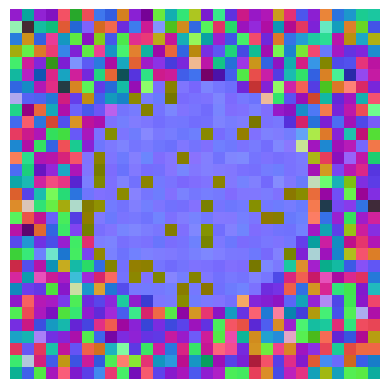

In [84]:
import numpy as np
import matplotlib.pyplot as plt

M = np.stack([x_1, x_2, x_3, x_4, x_5, x_6], axis=0)
Y = tensor_D(M)
# Assume Y is already defined with shape (3, 3, 31, 31, 31)
Z = np.zeros((3, 31, 31, 31))

for i in range(31):
    for j in range(31):
        for k in range(31):
            L = Y[:, :, i, j, k]
            # Eigen decomposition
            vals, vecs = np.linalg.eig(L)
            # Get eigenvector of largest eigenvalue
            principal_vec = vecs[:, np.argmax(vals)].real
            principal_vec /= np.linalg.norm(principal_vec)  # normalize

            # Projections (dot products)
            R = np.dot(principal_vec, [1, 0, 0])
            G = np.dot(principal_vec, [0, 1, 0])
            B = np.dot(principal_vec, [0, 0, 1])

            Z[:, i, j, k] = [R, G, B]

# Extract slice
slice_img = np.moveaxis(Z[:, 18, :, :], 0, -1)  # shape (31,31,3)

# Normalize to [0,1] for plotting
slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())

plt.imshow(slice_img)
plt.axis("off")
plt.show()

# X_rgb = np.moveaxis(Z, 0, -1)  # shape (31, 31, 31, 3)
# X_rgb = (X_rgb - X_rgb.min()) / (X_rgb.max() - X_rgb.min() + 1e-8)

# # Create a mask of which voxels are nonzero (or thresholded)
# mask = np.any(X_rgb > 0.1, axis=-1)  # boolean array (31,31,31)

# # Set up figure
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Plot voxels with colors
# ax.voxels(mask, facecolors=X_rgb, edgecolor=None)

# plt.show()

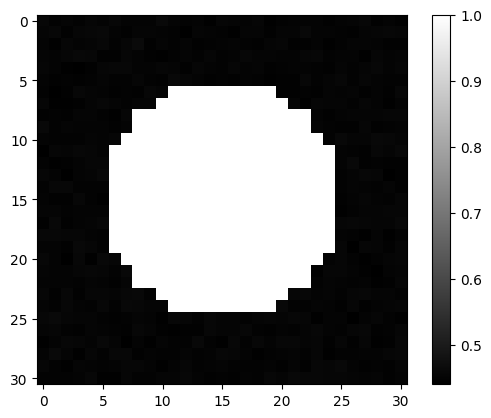

In [85]:

import matplotlib.pyplot as plt

plt.imshow(f[15, :, :], cmap="gray")
plt.colorbar()   # optional, shows the scale
plt.show()